# Régression logistique comme réseau de neurones

Objectif : Construire une régression logistique à la manière dont on construit un réseau de neurones. 

**Instructions:**
- Ne pas utiliser de boucles (for/while) à moins que ce ne soit explicitement demandé

**On va apprendre à:**
- Construire les briques principales d'un algorithme d'apprentissage:
    - Initialisation des paramètres
    - Calcul de la fonction coût et son gradient
    - Appliquer une optimisation (ici descente de gradient) 
- Organiser les 3 briques ci-dessus dans un seul algo d'apprentissage.

## 1 - Packages ##

Import des packages nécessaires
- [numpy](www.numpy.org)
- [h5py](http://www.h5py.org)
- [matplotlib](http://matplotlib.org) 
- [PIL](http://www.pythonware.com/products/pil/)
- [scipy](https://www.scipy.org/) 
- [pandas](https://pandas.pydata.org/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

## 2 - Présentation globale du problème

Télécharger le data set au lien :

http://www.robots.ox.ac.uk/~vgg/data/flowers/

**Hypothèses**:
Le dossier contient :
    - des images en jpg de tailles différentes
    - 17 catégories de fleurs

In [2]:
# Création de la matrice des images 
def create_data(path):
    """
    Crée un array contenant les valeurs RGB de chaque pixel et un array contenant les catégories
    Argument:
    - path chemin contenant le fichier téléchargé ci-dessus
    Ouput:
    - X coordonnées RGB de l'image resizée
    - Y catégorie de l'image
    """
    
    ### Images
    new_width  = 64
    new_height = 64
    with open(path+'/files.txt') as f:
        filenames=f.readlines()
    n_files = 160
    X = np.zeros((n_files,new_width, new_width, 3),dtype=int)
    for i,f in enumerate(filenames):
        if i in set(np.arange(881,960)):
                img = Image.open(path+'/'+f.rstrip())
                img = img.resize((new_width, new_height), Image.ANTIALIAS)
                rgb = np.array(img).astype(int)
                X[i-881,:,:,:] = rgb
        if i in set(np.arange(1121,1200)):
                img = Image.open(path+'/'+f.rstrip())
                img = img.resize((new_width, new_height), Image.ANTIALIAS)
                rgb = np.array(img).astype(int)
                X[i-1121+80,:,:,:] = rgb
        else:
            continue

     
    ### Labels
    Y=np.zeros(X.shape[0],dtype=int)
    #thresholds = np.arange(0,X.shape[0],80)
    #for i,s in enumerate(thresholds[:-1]):
    #    Y[s:thresholds[i+1]]=i
    #Y[thresholds[-1]:]= i+1
    Y[:80]=1
    
    sample = np.arange(80,X.shape[0])
    np.random.shuffle(sample)
    #X[80:160,:,:,:]=X[sample[:80],:,:,:]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    onehot_encoder = OneHotEncoder(sparse=False)
    
    Y_train = Y_train.reshape(len(Y_train), 1)
    Y_train = onehot_encoder.fit_transform(Y_train).astype(int)
    Y_train = Y_train[:,1].reshape(1,Y_train.shape[0])
    
    Y_test = Y_test.reshape(len(Y_test), 1)
    Y_test = onehot_encoder.fit_transform(Y_test).astype(int)
    Y_test = Y_test[:,1].reshape(1,Y_test.shape[0])

    classes = np.array([b'non buttercup', b'buttercup'], 
      dtype='|S13')
    return(X_train, X_test, Y_train, Y_test, classes)

In [3]:
X_train, X_test, Y_train, Y_test, classes = create_data('flower')

y = 0 c'est une image de non buttercup


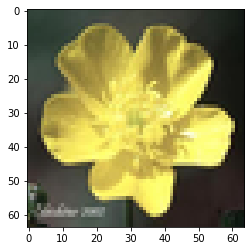

In [4]:
# Exemple d'image
index = 100
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[:,index])) + " c'est une image de " + classes[int(np.squeeze(Y_train[:,index]))].decode("utf-8"))

Lorsqu'on construit une architecture deep learning, on peut rencontrer de nombreux problèmes liés aux dimensions matrice/vecteur qui ne correspondent pas. En gardant un oeil sur les dimensions des différentes quantités matricielles, on peut s'affranchir d'un bon nombre de bugs

**Exercice** Afficher les valeurs suivantes:
    - m_train (taille de l'échantillon train)
    - m_test (taille de l'échantillon test)
    - num_px (nombre de pixel d'un côté du carré)

In [5]:
### START CODE HERE ### (≈ 3 lines of code)

m_train = X_train.shape[0]
m_test = X_test.shape[0]
num_px = X_train.shape[1]

### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(X_train.shape))
print ("train_set_y shape: " + str(Y_train.shape))
print ("test_set_x shape: " + str(X_test.shape))
print ("test_set_y shape: " + str(Y_test.shape))

Number of training examples: m_train = 128
Number of testing examples: m_test = 32
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (128, 64, 64, 3)
train_set_y shape: (1, 128)
test_set_x shape: (32, 64, 64, 3)
test_set_y shape: (1, 32)


**Ouput**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 128 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 32 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>

Par soucis de clareté, il faut maintenant redimensionner les images de taille (num_px,num_px,3) en un array de dimension (num_px $*$ num_px $*$ 3, 1). Nos echantillons test et train seront donc des np.array où chaque colonne représente une image *plate*.

**Exercice :** Transformer les échantillons test et train en np.array de dimensions (num_px $*$ num_px $*$ 3, 1).
*Indication :* Pour transformer une matrice de dimensions ($n_1$,...,$n_p$) en matrice $(\Pi n_i,n_1)$, on peut utiliser :
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T est la transposée de X
```

In [6]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)

X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(X_train_flatten.shape))
print ("train_set_y shape: " + str(Y_train.shape))
print ("test_set_x_flatten shape: " + str(X_test_flatten.shape))
print ("test_set_y shape: " + str(Y_test.shape))
print ("sanity check after reshaping: " + str(X_train_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 128)
train_set_y shape: (1, 128)
test_set_x_flatten shape: (12288, 32)
test_set_y shape: (1, 32)
sanity check after reshaping: [102 104  95  48  49]


**Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 128)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 128)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 32)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 32)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[69 103 203  76 110]</td> 
  </tr>
</table>

Une image est déterminée par les coordonnées RGB de chaque pixel qui définissent la couleur du pixel en question. Ainsi un pixel est un vecteur de dimension 3 contenant des valeurs entre 0 et 255.

Il est commun en machine learning de normaliser les datasets (moyenne 0, variance 1). Pour les images il est plus simple (et cela fonctionne aussi très bien) de juste diviser par la valeur max de chaque coordonnée.

**Warning**
Durant l'entrainement, on est amené à multiplier les poids et additioner le biais des différents inputs afin de juger de l'activation et ensuite on rétropropage le gradient. Il est EXTREMEMENT important que toutes les features à l'entrée d'un neurones aient le même ordre de grandeur pour éviter que le gradient ne prenne des valeurs extrêmes.

In [7]:
# Normalisation
### START CODE HERE ### (≈ 2 lines of code)
max_arr_train = np.amax(X_train_flatten, axis=0)
max_arr_test = np.amax(X_test_flatten, axis=0)

X_train_flatten_normalized = X_train_flatten / max_arr_train
X_test_flatten_normalized = X_test_flatten / max_arr_test
### END CODE HERE ###

/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_1487/2320659124.py:6: RuntimeWarning: invalid value encountered in true_divide
  X_train_flatten_normalized = X_train_flatten / max_arr_train


## 3 - Architecture générale ##

On va maintenant construire un algorithme simple pour faire la distinction entre les deux catégorie de fleurs. On va construire une régression logistique en prenant le point de vue réseau de neurones. 


**Expressions mathématiques**:

Pour un exemple $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = \sigma(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

La fonction coût est obtenue comme la somme des $\mathcal{L}$ de chaque exemple:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Les étapes**:
Dans cet exercice, on va s'attaquer aux étapes suivantes:
    - Initialiser les paramètres du modèle
    - Apprendre les paramètres du modèle en minimisant $J$
    - Utiliser les paramètres pour faire les prédictions
    - Analyser les résultats et conclure

## 4 - Construire les différentes briques de notre algorithme ##

Les étapes principales pour construire un réseau de neurones sont les suivantes:
1. Définir l'architecture du modèle (connections, taille de l'input, fonctions d'activations, etc...)
2. Initialiser les paramètres du modèle
3. Boucle :
    - Calculer le coût (forward propagation)
    - Calculer le gradient associé (backward propagation)
    - Mettre à jour les paramètres (descente de gradient)

En règle générale, on travaille séparèment sur les 3 points puis les intègre dans une fonction `model()`.

### 4.1 - Fonctions utiles

**Exercise**: Implémenter la fonction `sigmoid()` qui est notamment utilisé pour calculer $\sigma( w^T x + b)$, la probabilité d'être dans la classe 1 (snowdrop).

In [8]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    
    s = 1/(1+np.exp(-z))

    ### END CODE HERE ###
    
    return s

In [9]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


**Output**: 

<table style="width:20%">
  <tr>
    <td>**sigmoid(0)**</td>
    <td> 0.5</td> 
  </tr>
  
  <tr>
    <td>**sigmoid(9.2)**</td>
    <td> 0.999898970806 </td> 
  </tr>
</table>

### 4.2 - Initialisation

**Exercise:** Implémenter l'initialisation des paramètres (*cf* `np.zeros()`).

In [10]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    
    w, b = np.zeros([dim,1]), 0

    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [11]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Output**: 

<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Pour les images, w sera de taille (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward et Backward propagation

Maintenant que les paramètres sont initialisés, on peut effectuer les propagations *"forward"* et *"backward"* afin d'ajuster les paramètres au cours de l'apprentissage.



**Exercice:** Implémenter la fonction `propagate()` qui calcule le coût et son gradient.

**Indications**:

Forward Propagation:
- On connait X
- On calcule $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- On calcule ensuite: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Voici les deux formules que vous utiliserez : 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [12]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))    
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [13]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### d) Optimization
Jusqu'ici on a:
- initialisé les paramètres
- créé une fonction pour calculer la fonction coût et son gradient

Il s'agit maintenant de mettre à jour les paramètres au moyen la descente du gradient.

**Exercice:** Implémenter la fonction d'optimisation. Le but est d'apprendre $w$ et $b$ en minimisant la fonction $J$. 

**Rappel**: Pour un paramètre $\theta$, on applique $ \theta = \theta - \alpha \text{ } d\theta$, où $\alpha$ est le *learning rate*.


In [14]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        ### START CODE HERE ### 
        dw = grads["dw"]
        db = grads["db"]
        ### END CODE HERE ###
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.1124579 ]
 [ 0.23106775]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.90158428]
 [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.430462071679 </td>
    </tr>

</table>

**Exercise:** La fonction ci-dessus renvoie en sortie les paramètres appris w et b. On est maintenant en mesure de les utiliser w et b pour prédire les labels pour un dataset X. Il faut donc implémenter la fonction `predict()`. Pour cela, procédons en deux étapes :
1. Calculer $\hat{Y} = A = \sigma(w^T X + b)$
2. Convertir $\hat{Y}$ en booléen (0 si $A \leq 0.5$, $1$ sinon), stocker les prédictions dans un vecteur `Y_prediction`. Si vous le souhaitez, vous pouvez utiliser `if`/`else` dans une boucle `for` même s'il existe aussi un moyen de le faire en vectoriel.


In [16]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [17]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>

<font color='blue'>
**Ce qu'il faut retenir:**
    
On a implémenté plusieurs fonctions :
-  Initialiser(w,b)
-  Optimiser la fonction coût pour apprendre les paramètres (w,b) optimaux en:
    - calculant le coût et son gradient
    - mettant à jour les paramètres en *descendant* le long du gradient
- Utiliser (w,b) pour prédire la classe d'un échantillon X

## 5 - Merge all functions into a model ##

On va maintenant voir comment le model s'articule en rassemblant tous les blocks dans une même fonction..

**Exercise:** Implémenter la fonction `model` en utilisant les notations suivantes :
    - Y_prediction pour la prédiction sur le test
    - Y_prediction_train pour la prédiction sur le train 
    - w, costs, grads pour les outputs de optimize()

In [18]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = np.zeros((X_train.shape[0],1)), 0

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w, b = parameters["w"], parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [19]:
d = model(X_train_flatten_normalized, Y_train, X_test_flatten_normalized, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: nan
Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
train accuracy: 50.0 %
test accuracy: 50.0 %
